In [1]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import os
import matplotlib.patches as patches

In [2]:
# arguments
cam_H, cam_W = 580, 890
wvls = np.arange(420, 670, 10)
patch_size = 25
n_illum = 128
n_patches = 4
n_channel = 3
patch_name = ["red", "green", "blue", "white"]

## Get R,G,B,W patches information

Text(0.5, 0, 'wavelength [nm]')

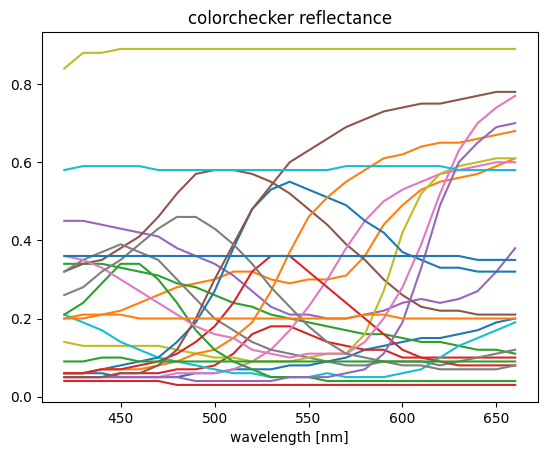

In [3]:
# Replace 'file.csv' with the path to your CSV file
file_path = './dataset/MacbethColorChecker.csv'
# Read the CSV file and store it as a DataFrame
df = pd.read_csv(file_path, header=None, skiprows=2)

# Display the DataFrame
wvls_CC = df.values[1:,0]
wvls_CC = [float(x) for x in wvls_CC] 
ref_CC = df.values[1:,1:-2]

ind_min = 6
ind_max = 61
wvls_CC = wvls_CC[ind_min:ind_max:2] 
ref_CC = ref_CC[ind_min:ind_max:2,:]

# print(wvls_CC, ref_CC)

plt.figure()
plt.plot(wvls_CC[1:-2], ref_CC[1:-2])
plt.title('colorchecker reflectance')
plt.xlabel('wavelength [nm]')

In [4]:
ref_CC[:, 0] # 1번째 idx 는 wvl 에 대한 정보 / 두번째 idx는 patch 1부터 24까지

array([0.07, 0.06, 0.06, 0.06, 0.05, 0.05, 0.05, 0.05, 0.06, 0.06, 0.07,
       0.07, 0.07, 0.08, 0.08, 0.09, 0.1, 0.12, 0.13, 0.14, 0.15, 0.15,
       0.16, 0.17, 0.19, 0.2, 0.22, 0.24], dtype=object)

In [5]:
blue = ref_CC[1:-2,12] # 87, 370
green = ref_CC[1:-2,13] # 218, 370
red = ref_CC[1:-2,14] # 349, 376
white = ref_CC[1:-2,18] # 74, 500

In [6]:
center_pts = np.array([[407,387],[278,385],[145,375],[141,500]]) # R, G, B, W

In [7]:
color_check_hyp_gt = np.zeros(shape=(cam_H, cam_W, len(wvls)))

In [8]:
color_check_hyp_gt[center_pts[0,1]-patch_size:center_pts[0,1]+patch_size, center_pts[0,0]-patch_size:center_pts[0,0]+patch_size] = red
color_check_hyp_gt[center_pts[1,1]-patch_size:center_pts[1,1]+patch_size, center_pts[1,0]-patch_size:center_pts[1,0]+patch_size] = green
color_check_hyp_gt[center_pts[2,1]-patch_size:center_pts[2,1]+patch_size, center_pts[2,0]-patch_size:center_pts[2,0]+patch_size] = blue
color_check_hyp_gt[center_pts[3,1]-patch_size:center_pts[3,1]+patch_size, center_pts[3,0]-patch_size:center_pts[3,0]+patch_size] = white

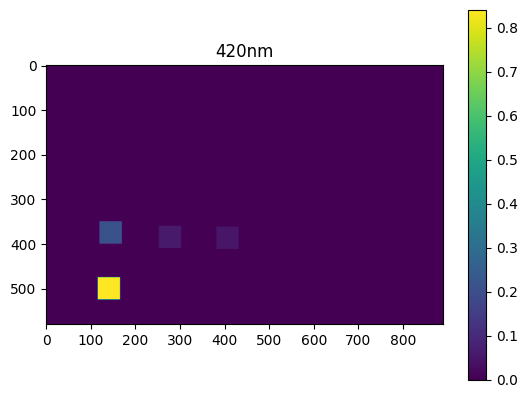

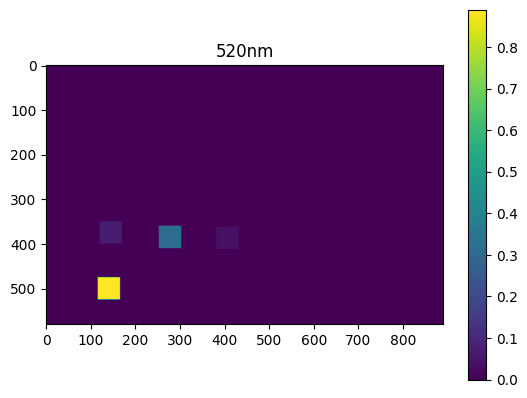

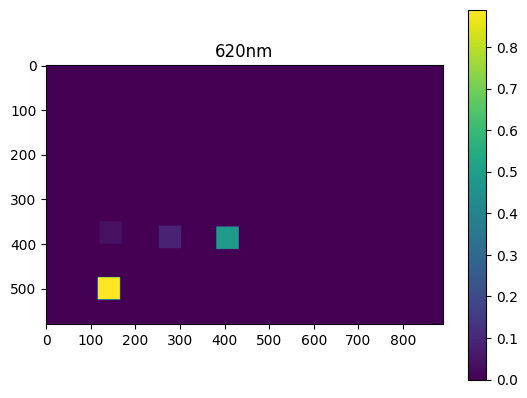

In [9]:
for i in range(0,25,10):
    plt.imshow(color_check_hyp_gt[:,:,i]), plt.colorbar(), plt.title("%snm"%wvls[i])
    plt.show()

In [10]:
# np.save('color_check_hyp_gt.npy', color_check_hyp_gt)

## Plotting Graph

### RGB intensity

In [11]:
N3_arr_real_hdr = np.load('./calibration/ldr_step5.npy') / 65535.
N3_arr_real_hdr = N3_arr_real_hdr[:,:,:,::-1].transpose(1,2,0,3)

# N3_arr_real = np.load('./N3_arr_real.npy')
N3_arr_simulation = np.load('./N3_arr_simulation.npy')

In [12]:
# N3_arr_real = N3_arr_real.reshape(cam_H, cam_W, n_illum, 3)
N3_arr_real = N3_arr_real_hdr.reshape(cam_H, cam_W, n_illum, 3)
N3_arr_simulation = N3_arr_simulation.reshape(cam_H, cam_W, n_illum, 3)

In [13]:
N3_arr_simulation.max()

0.63198966

##### Patch Test

In [14]:
# green cneter point에 초록색 파장의 first order가 닿았을 때 : 93 patt
# green cneter point에 초록색 파장의 first order가 닿았을 때 : 103 patt
p = 1 # G
print('simulation : ', N3_arr_simulation[center_pts[p][1], center_pts[p][0], 93])# 57에서 Red white pattern light
print('real : ', N3_arr_real_hdr[center_pts[p][1], center_pts[p][0], 93]) # 57에서 Red white pattern light

# green cneter point에 아무것도 안닿았을 때 : 23 patt
p = 1 # G
print('simulation : ', N3_arr_simulation[center_pts[p][1], center_pts[p][0], 23])# 57에서 Red white pattern light
print('real : ', N3_arr_real_hdr[center_pts[p][1], center_pts[p][0], 23]) # 57에서 Red white pattern light

# blue cneter point에 아무것도 안닿았을 때 : 60 patt
p = 2 # G
print('simulation : ', N3_arr_simulation[center_pts[p][1], center_pts[p][0], 60])# 57에서 Red white pattern light
print('real : ', N3_arr_real_hdr[center_pts[p][1], center_pts[p][0], 60]) # 57에서 Red white pattern light

p = 1 # G
N3_arr_real[center_pts[p][1], center_pts[p][0], 93] # 57에서 Red white pattern light

p = 2 # B 
print('real : ',N3_arr_real[center_pts[p][1], center_pts[p][0], 28]) # 57에서 Red white pattern light
print('simulation : ',N3_arr_simulation[center_pts[p][1], center_pts[p][0], 28]) # 57에서 Red white pattern light

p = 0 # R
print('real : ',N3_arr_real_hdr[center_pts[p][1], center_pts[p][0], 57]) # 57에서 Red white pattern light
print('simulation : ',N3_arr_simulation[center_pts[p][1], center_pts[p][0], 57]) 

p = 3 # W
print('real : ',N3_arr_real_hdr[center_pts[p][1], center_pts[p][0], 27]) # 57에서 Red white pattern light
print('simulation : ',N3_arr_simulation[center_pts[p][1], center_pts[p][0], 27])

p = 1 # G
print('real : ',N3_arr_real_hdr[center_pts[p][1], center_pts[p][0], 42]) # 57에서 Red white pattern light
print('simulation : ',N3_arr_simulation[center_pts[p][1], center_pts[p][0], 42]) # 57에서 Red white pattern light

simulation :  [2.8896598e-05 2.4229441e-04 1.9448971e-03]
real :  [0.00073243 0.00146487 0.00390631]
simulation :  [0. 0. 0.]
real :  [0.00024414 0.         0.        ]
simulation :  [0. 0. 0.]
real :  [0.00097658 0.00097658 0.        ]
real :  [0.00048829 0.         0.        ]
simulation :  [0. 0. 0.]
real :  [0.00341802 0.00195315 0.00048829]
simulation :  [0. 0. 0.]
real :  [0.00195315 0.00341802 0.00073243]
simulation :  [0. 0. 0.]
real :  [0.         0.00097658 0.        ]
simulation :  [0. 0. 0.]


#### Plotting Real & Simulation

In [15]:
# plot reflectance for each patches - real
# patches : 24개, wvl : 25 개

patches_rgb_real = np.zeros(shape = (n_illum, n_channel, n_patches))
patches_idx = center_pts

for l in range(n_illum):
    for p in range(n_patches):
        for c in range(n_channel):
            x_idx, y_idx = patches_idx[p][0], patches_idx[p][1]
            rgb_intensity = N3_arr_real[y_idx, x_idx, l, c]
            # print('illum num %s, patch num %s, channel num %s' %(l, p, c),rgb_intensity)
            patches_rgb_real[l, c, p] = rgb_intensity

In [16]:
# plot reflectance for each patches - simulation
# patches : 24개, wvl : 25 개

patches_rgb = np.zeros(shape = (n_illum, n_channel, n_patches))
patches_idx = center_pts

for l in range(n_illum):
    for p in range(n_patches):
        for c in range(n_channel):
            x_idx, y_idx = patches_idx[p][0], patches_idx[p][1]
            rgb_intensity = N3_arr_simulation[y_idx, x_idx, l, c]
            patches_rgb[l, c, p] = rgb_intensity

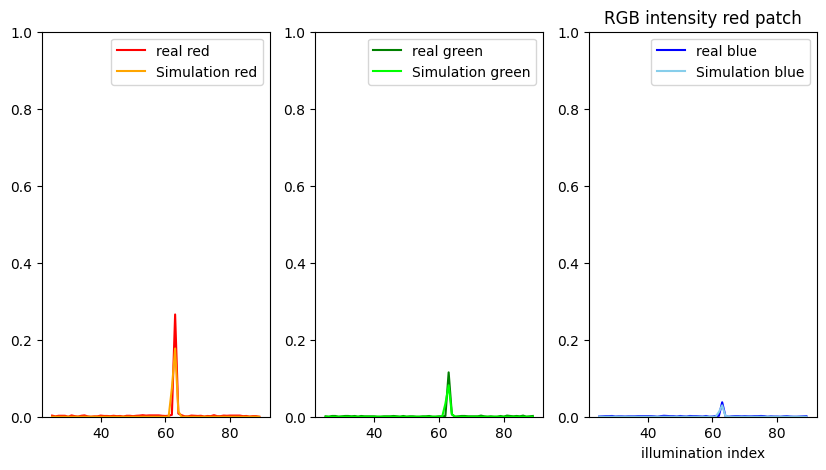

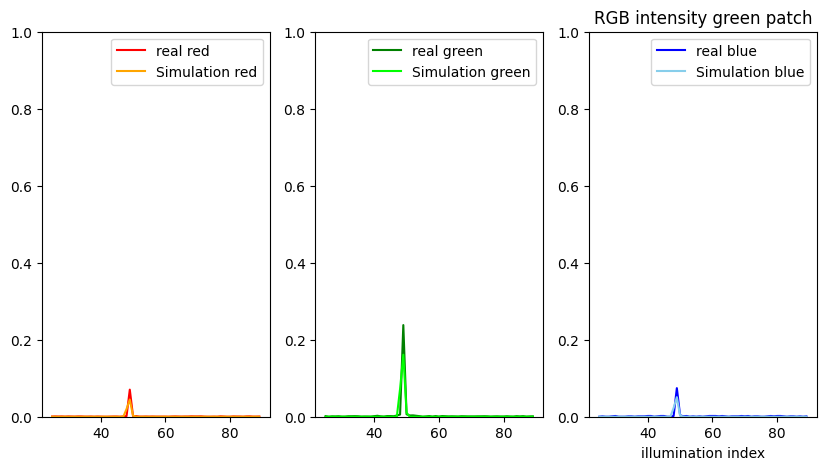

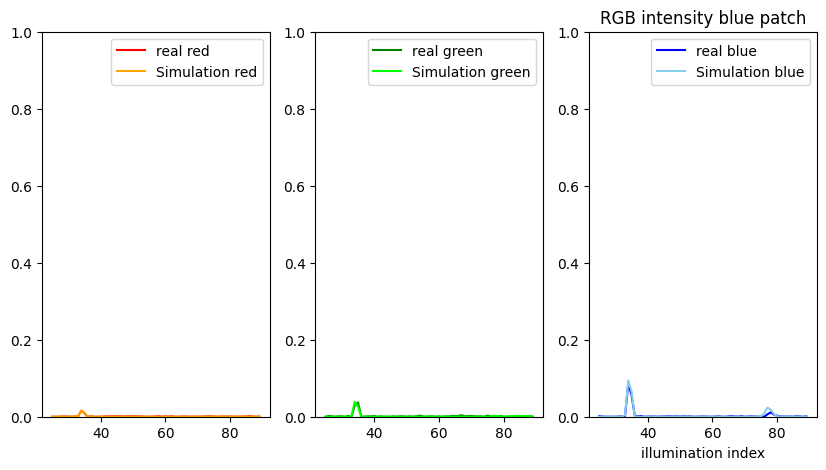

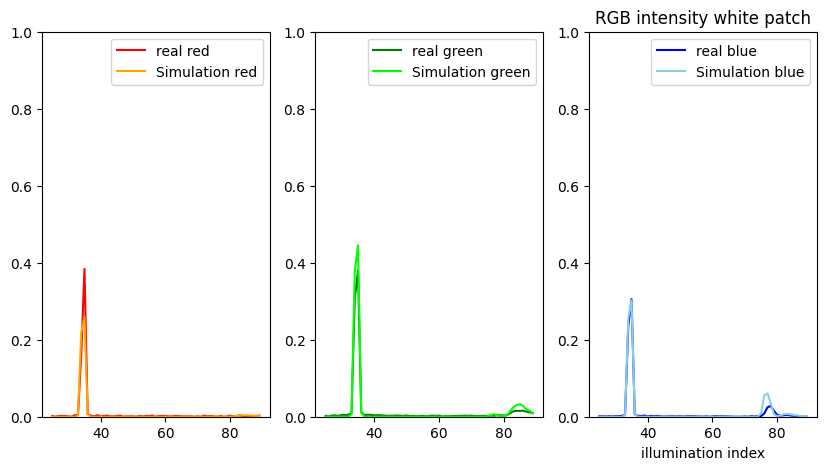

In [17]:
illum = np.arange(0, n_illum, 1)

start_idx = 25
end_idx = 90

for p in range(n_patches):
    plt.figure(figsize = (10,5))

    plt.subplot(131), plt.plot(illum[start_idx: end_idx], patches_rgb_real[start_idx: end_idx, 0, p], label = 'real red', c = 'red'), plt.legend(), plt.ylim(0,1)
    plt.subplot(132), plt.plot(illum[start_idx: end_idx], patches_rgb_real[start_idx: end_idx, 1, p], label = 'real green', c = 'green'), plt.legend(), plt.ylim(0,1)
    plt.subplot(133), plt.plot(illum[start_idx: end_idx], patches_rgb_real[start_idx: end_idx, 2, p], label = 'real blue', c = 'blue'), plt.legend(), plt.ylim(0,1)
    
    # plt.title('RGB intensity Real %s patch'%patch_name[p])
    # plt.xlabel('illumination index')
    
    plt.subplot(131), plt.plot(illum[start_idx: end_idx], patches_rgb[start_idx: end_idx, 0, p], label = 'Simulation red', c = 'orange'), plt.legend(), plt.ylim(0,1)
    plt.subplot(132), plt.plot(illum[start_idx: end_idx], patches_rgb[start_idx: end_idx, 1, p], label = 'Simulation green', c = 'lime'), plt.legend(), plt.ylim(0,1)
    plt.subplot(133), plt.plot(illum[start_idx: end_idx], patches_rgb[start_idx: end_idx, 2, p], label = 'Simulation blue', c = 'skyblue'), plt.legend(), plt.ylim(0,1)

    plt.title('RGB intensity %s patch'%patch_name[p])
    plt.xlabel('illumination index')
    

### Hyperspectral reconstruction

#### Real

In [18]:
X_np_all_real = np.load('./X_np_all_real_px.npy').reshape(4, len(wvls))
# X_np_all_real = np.load('./X_np_all_step_tv.npy').reshape(cam_H, cam_W, len(wvls))
X_np_all = np.load('./X_np_all.npy').reshape(cam_H, cam_W, len(wvls))

In [19]:
X_np_all.shape

(580, 890, 25)

In [20]:
# Image plotting for image hyperspectral reconstruction

# max_images_per_column = 5
# num_columns = (len(wvls) + max_images_per_column - 1) // max_images_per_column
# plt.figure(figsize=(15, 3*num_columns))

# for c in range(num_columns):
#     start_index = c * max_images_per_column
#     end_index = min(start_index + max_images_per_column, len(wvls))
#     num_images = end_index - start_index
    
#     for i in range(num_images):
#         plt.subplot(num_columns, num_images, i + c * num_images + 1)
#         plt.imshow(X_np_all_real[:, :, i + start_index], vmin=0, vmax=1)
#         plt.axis('off')
#         # plt.title(f"Image {i + start_index}")
#         plt.title("%snm"%wvls[i+start_index])
#         if i + start_index == len(wvls) - 1:
#             plt.colorbar()

In [21]:
# # plot reflectance for each patches
# # patches : 24개, wvl : 25 개

# patches_reflectance_real = np.zeros(shape = (len(wvls), n_patches))
# patches_idx = center_pts

# for p in range(n_patches):
#     for w in range(len(wvls)):
#         x_idx, y_idx = patches_idx[p][0], patches_idx[p][1]
#         mean_ref = X_np_all_real[y_idx-patch_size:y_idx+patch_size,x_idx-patch_size:x_idx+patch_size, w].mean()
#         patches_reflectance_real[w, p] = mean_ref

In [22]:
# img = X_np_all_real[...,21]

# fig, ax = plt.subplots()
# for p in range(n_patches):
#     plt.plot(patches_idx[p][0],patches_idx[p][1], "*")
#     ax.add_patch(patches.Rectangle([patches_idx[p][0]-patch_size,patches_idx[p][1]-patch_size], patch_size*2, patch_size*2, fill = False, edgecolor = 'red'))
#     plt.imshow(img, vmin = 0., vmax = 1.)

In [23]:
# patches_ref_clip_real = np.clip(patches_reflectance_real, 0 ,1)

#### Simulation

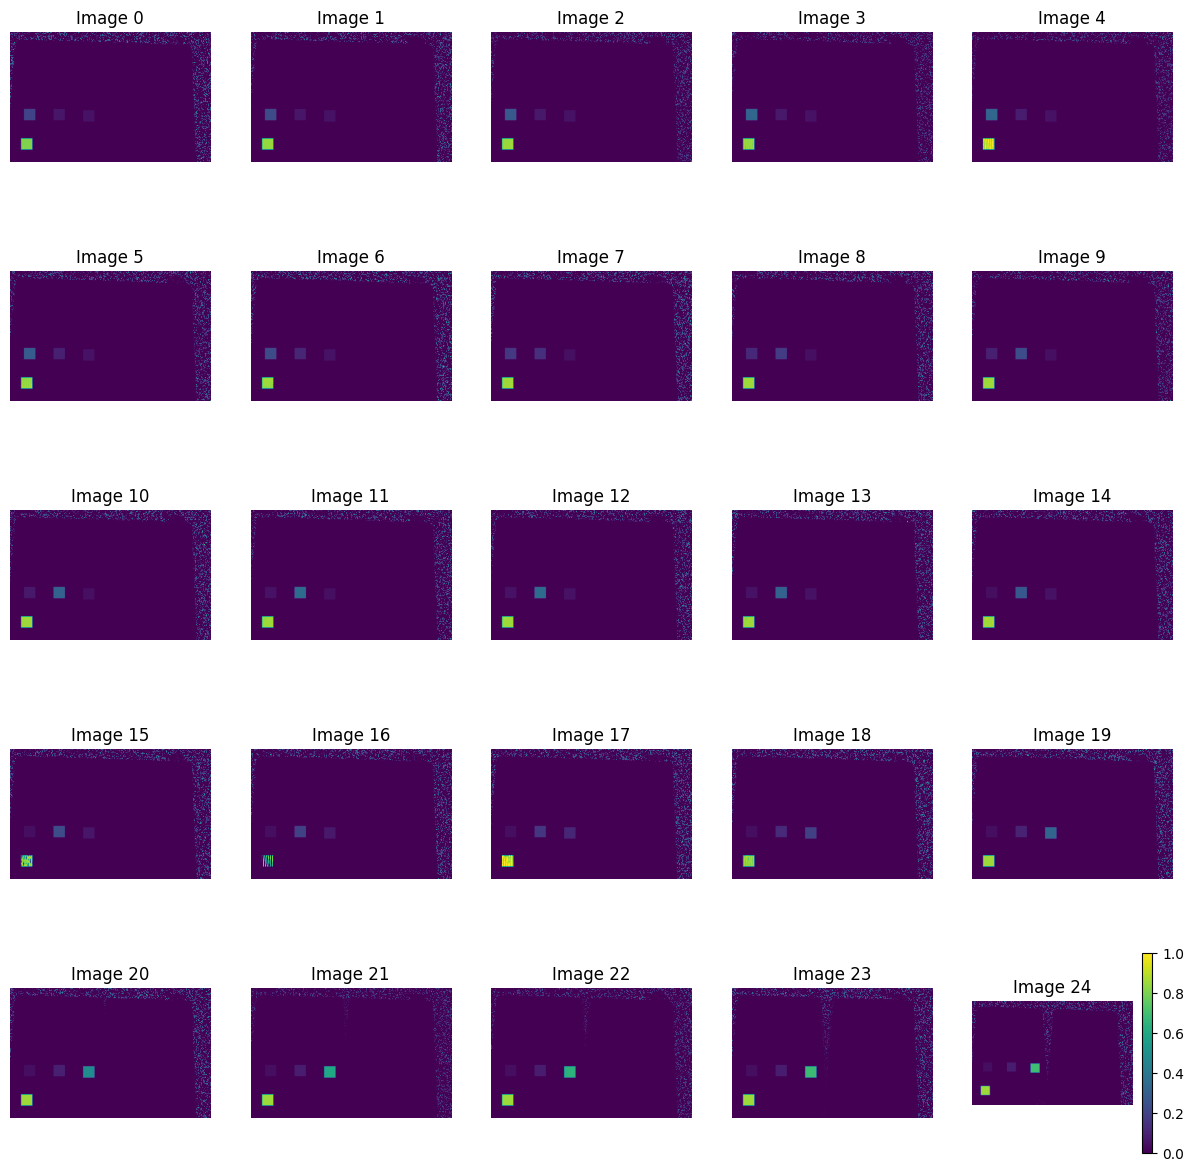

In [24]:
max_images_per_column = 5
num_columns = (len(wvls) + max_images_per_column - 1) // max_images_per_column
plt.figure(figsize=(15, 3*num_columns))

for c in range(num_columns):
    start_index = c * max_images_per_column
    end_index = min(start_index + max_images_per_column, len(wvls))
    num_images = end_index - start_index
    
    for i in range(num_images):
        plt.subplot(num_columns, num_images, i + c * num_images + 1)
        plt.imshow(X_np_all[:, :, i + start_index], vmin=0, vmax=1)
        plt.axis('off')
        plt.title(f"Image {i + start_index}")
        
        if i + start_index == len(wvls) - 1:
            plt.colorbar()

In [25]:
# plot reflectance for each patches
# patches : 24개, wvl : 25 개

patches_reflectance = np.zeros(shape = (len(wvls), n_patches))
patches_idx = center_pts

patch_size = 0

for p in range(n_patches):
    for w in range(len(wvls)):
        x_idx, y_idx = patches_idx[p][0], patches_idx[p][1]
        mean_ref = X_np_all[y_idx-patch_size:y_idx+patch_size,x_idx-patch_size:x_idx+patch_size, w].mean()
        patches_reflectance[w, p] = mean_ref

c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice.
  if sys.path[0] == "":
c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


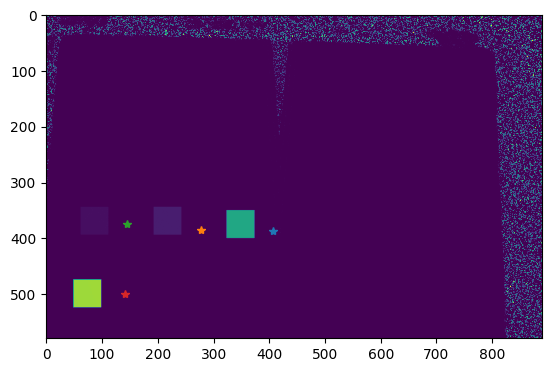

In [26]:
img = X_np_all[...,21]

fig, ax = plt.subplots()
for p in range(n_patches):
    plt.plot(patches_idx[p][0],patches_idx[p][1], "*")
    ax.add_patch(patches.Rectangle([patches_idx[p][0]-patch_size,patches_idx[p][1]-patch_size], patch_size*2, patch_size*2, fill = False, edgecolor = 'red'))
    plt.imshow(img, vmin = 0., vmax = 1.)

In [27]:
patches_ref_clip = np.clip(patches_reflectance, 0 ,1)

In [28]:
patches_ref_clip.shape

(25, 4)

### Reflectance Comparison

In [29]:
X_np_all_real.min()

-1.9242986

Text(0.5, 0, 'wavelength [nm]')

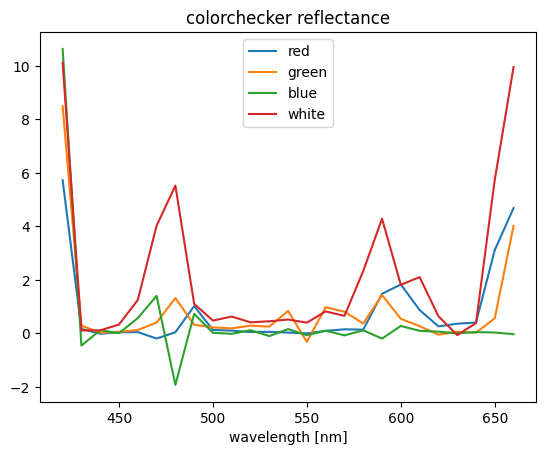

In [30]:
plt.figure()

# plt.plot(wvls, patches_ref_clip_real[:,0], label = 'red')
# plt.plot(wvls, patches_ref_clip_real[:,1], label = 'green')
# plt.plot(wvls, patches_ref_clip_real[:,2], label = 'blue')
# plt.plot(wvls, patches_ref_clip_real[:,3], label = 'white')

plt.plot(wvls, X_np_all_real[0], label = 'red')
plt.plot(wvls, X_np_all_real[1], label = 'green')
plt.plot(wvls, X_np_all_real[2], label = 'blue')
plt.plot(wvls, X_np_all_real[3], label = 'white')

plt.legend()
plt.title('colorchecker reflectance')
plt.xlabel('wavelength [nm]')

In [31]:
X_np_all_px = np.load('./X_np_all_px.npy').reshape(4, len(wvls))

In [32]:
X_np_all_px.shape

(4, 25)

Text(0.5, 0, 'wavelength [nm]')

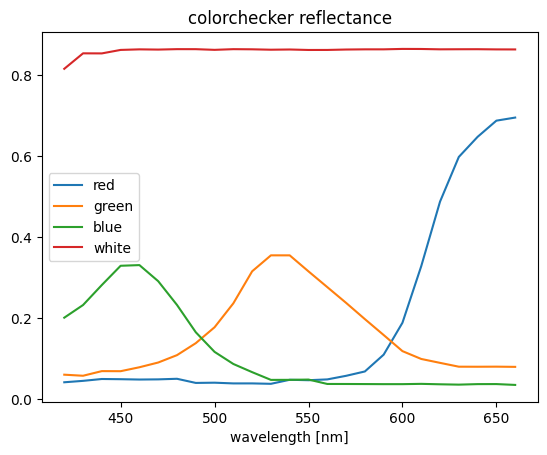

In [36]:
plt.figure()
# plt.plot(wvls, patches_ref_clip[:,0], label = 'red')
# plt.plot(wvls, patches_ref_clip[:,1], label = 'green')
# plt.plot(wvls, patches_ref_clip[:,2], label = 'blue')
# plt.plot(wvls, patches_ref_clip[:,3], label = 'white')

plt.plot(wvls, X_np_all_px[0], label = 'red')
plt.plot(wvls, X_np_all_px[1], label = 'green')
plt.plot(wvls, X_np_all_px[2], label = 'blue')
plt.plot(wvls, X_np_all_px[3], label = 'white')

# plt.ylim(0, 1)
plt.legend()
plt.title('colorchecker reflectance')
plt.xlabel('wavelength [nm]')

In [34]:
patches_ref_clip.shape

(25, 4)

Text(0.5, 0, 'wavelength [nm]')

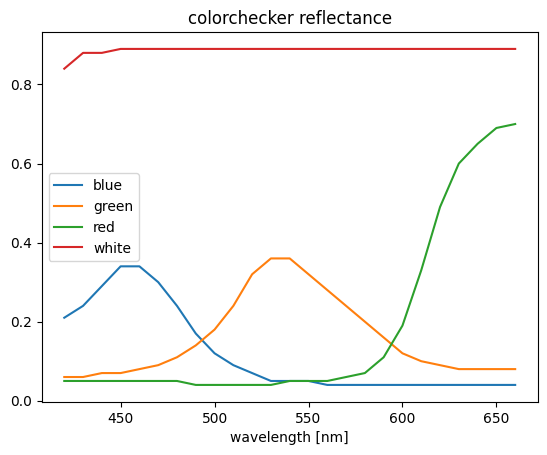

In [35]:
plt.figure()
plt.plot(wvls_CC[1:-2], ref_CC[1:-2,12], label = 'blue')
plt.plot(wvls_CC[1:-2], ref_CC[1:-2,13], label = 'green')
plt.plot(wvls_CC[1:-2], ref_CC[1:-2,14], label = 'red')
plt.plot(wvls_CC[1:-2], ref_CC[1:-2,18], label = 'white')

plt.legend()
plt.title('colorchecker reflectance')
plt.xlabel('wavelength [nm]')